In [1]:
import os

os.environ[
    "OMP_NUM_THREADS"
] = "128"  # for jupyter.nersc.gov otherwise the notebook only uses 2 cores

import seaborn as sns

sns.set_context("talk")
# sns.set()
sns.set_style("ticks")

import matplotlib as mpl
mpl.rc('image', cmap='coolwarm')

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy as np
import healpy as hp

In [3]:
from fgbuster.observation_helpers import get_noise_realization

In [4]:
from fgbuster import (CMB, Dust, Synchrotron, AnalyticComponent,
                      basic_comp_sep, 
                      get_observation, get_instrument)

In [5]:
from fgbuster.separation_recipes import harmonic_ilc as hilc


In [6]:
from plancklens.utils import camb_clfile
from lenspyx import synfast

In [7]:
import pysm3
import pysm3.units as u

In [8]:
from common import convert_units

In [10]:
cls_path = '/global/homes/j/jianyao/non_gau_lensing/theory/cls/'

In [248]:
noise_test = get_noise_realization(256, instrument)

In [251]:
nl = hp.anafast(noise_test[0])

In [254]:
np.var(noise_test[0][0])

26.76715185176525

In [256]:
def nlev2sig(nlev, nside):
    
    return np.sqrt((np.pi*nlev/10800)**2*(12*nside**2)/4/np.pi)

# simulations, including HILC

In [28]:
convert_units('uK_RJ', 'uK_CMB', 27)

array(1.01897896)

In [50]:
class simulations:
    
    def __init__(self, nside, instrument, e_n_d = False):
        
        self.nside = nside
        self.instrument = instrument
        self.fres = instrument['frequency']
        self.fwhms = instrument['fwhm']
        self.end = e_n_d
        
    def get_all(self, add_foreground = 'd0', noise = 'alms'):

        '''
        return one realization of (lensed CMB + foreground) with the beam applied + noise, 
        for each frequency defined in the instrument.
        
        noise: get noise alms or maps. 
        
        e_n_d: extra noise debias, to generate many noise realizations. 
        '''

        cl_unl = camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lenspotentialCls.dat'))
        geom_info = ('healpix', {'nside':nside}) # Geometry parametrized as above, this is the default

        lmax_unl = 3*nside
        cmb_temp = synfast(cl_unl, lmax=lmax_unl, verbose=0, geometry=geom_info, alm = False)
        self.cmb_len = np.row_stack((cmb_temp['T'], cmb_temp['QU'])) # (3, 12*nside**2)

        Nf = self.fres.size
        cmb_maps = np.repeat(self.cmb_len[np.newaxis, :, :], Nf, axis = 0)
             
        if add_foreground.startswith('d'):
            # for pysm3 pre-defined models
            sky = pysm3.Sky(nside, preset_strings = [add_foreground])
            foreground = get_observation(instrument, sky = sky, nside=nside, noise=False, unit='uK_CMB')
            
        elif add_foreground.startswith('forse'):
            
            pysm_model = add_foreground.split('_')[1]
            
            foreground = self.rescale_forse(self.fres, pysm_model = pysm_model)
        
        elif add_foreground == 'no_fore':
            # test case for only noise
            foreground = np.zeros_like(cmb_maps)
            
        noise_maps = get_noise_realization(self.nside, instrument, unit='uK_CMB')
        noise_alms = []
        
        if self.end is True: 
            noise_maps_end = []
            N = 20
            for n in range(N):
                noise_map_i = get_noise_realization(self.nside, instrument, unit='uK_CMB')
                noise_maps_end.append(noise_map_i)
                
            self.extra_noise = noise_maps_end
            self.N = N
                
        map_all = cmb_maps + foreground
        for i in range(Nf):
            # map_all[i] = pysm3.apply_smoothing_and_coord_transform(map_all[i], fwhm=self.fwhms[i]*u.arcmin) + self.noise_maps[i]
            map_all[i] = hp.smoothing(map_all[i], fwhm = self.fwhms[i]/180/60*np.pi) + noise_maps[i]
            foreground[i] = hp.smoothing(foreground[i], fwhm = self.fwhms[i]/180/60*np.pi)
            
            if noise == 'alms':
                noise_alms.append(hp.map2alm(noise_maps[i]))
                
        if noise == 'maps':
            self.noise_maps = noise_maps
        elif noise == 'alms':
            self.noise_alms = noise_alms
                
        self.map_all = map_all
        self.fg = foreground
        
    def rescale_forse(self, fres, pysm_model = 'd0'):
        '''
        Possible problem: hp.udgrade is used for nside changes; better choice: pysm3.apply_smoothing_and_coord_transform
        '''
                
        my_dust = self.model_forse(pysm_model)
            
        if fres.size > 1:
            _observations = np.zeros((len(fres), 3, 12*self.nside**2))
            for i in range(len(fres)):
                _observations[i] = my_dust.get_emission(fres[i] * u.GHz)*convert_units('uK_RJ', 'uK_CMB', fres[i])
                
        else:
            assert fres.size == 1
            _observations = my_dust.get_emission(fres * u.GHz)*convert_units('uK_RJ', 'uK_CMB', fres)
        
        return _observations
    
    def apply_hilc(self, components, lbins):
        
        '''
        apply fgbuster.hilc method to get clean CMB map
        '''
        
        results = hilc(components, self.instrument, self.map_all, lbins) 
        ### data are deconvolved when transforming to alms, 
        ### then using harmonic_ilc_alm to do the component separation
        weighted_alms = []
        
        noise_alms_ilc = np.copy(self.noise_alms)
        
        for i in range(self.fres.size):
            bl = hp.gauss_beam(np.radians(self.fwhms[i]/60.0), lmax = lbins[-1], pol=True)
            # all_alms = hp.map2alm(self.map_all[i], lmax = lbins[-1])
            fg_alms = hp.map2alm(self.fg[i], lmax = lbins[-1])
            
            for j in range(3): # T, E, B
                # hp.almxfl(all_alms[j], results.W[j, :, 0, i]/bl[:, j], inplace = True)  ### to mimic the HILC method: simulated total maps are deconvolved
                hp.almxfl(fg_alms[j], results.W[j, :, 0, i]/bl[:, j], inplace = True)
                hp.almxfl(noise_alms_ilc[i][j], results.W[j, :, 0, i]/bl[:, j], inplace = True)  ### simulated ilc noise maps are not deconvolved during the component separation
                
            # weighted_alms.append(all_alms)
            weighted_alms.append(fg_alms)
            
        fg_ilc_alms = np.sum(weighted_alms, axis = 0)
        # cmb_alms = np.sum(weighted_alms, axis = 0)
        noise_ilc_alms = np.sum(noise_alms_ilc, axis = 0) 
        
        if self.end is True:
            nls = []
            for n in range(self.N):
                _noise_alms_ilc = []

                for i in range(self.fres.size):
                    bl = hp.gauss_beam(np.radians(self.fwhms[i]/60.0), lmax = lbins[-1], pol=True)

                    _noise_alm_i = hp.map2alm(self.extra_noise[n][i], lmax = lbins[-1])

                    for j in range(3):
                        hp.almxfl(_noise_alm_i[j], results.W[j, :, 0, i]/bl[:, j], inplace = True)

                    _noise_alms_ilc.append(_noise_alm_i)

                _noise_alms = np.sum(_noise_alms_ilc, axis = 0) 
                nls.append(hp.alm2cl(_noise_alms))

            return results, noise_ilc_alms, fg_ilc_alms, nls
        else:

            return results, noise_ilc_alms, fg_ilc_alms
    
    def model_forse(self, pysm_model):
        
        dust_dir = "/pscratch/sd/j/jianyao/data_lensing/processed_dust_maps/"
        if pysm_model == 'd0':
            my_dust = pysm3.ModifiedBlackBody(
                nside = self.nside,
                map_I = "pysm_2/dust_t_new.fits",
                map_Q = dust_dir + "forse_dust_Q_353GHz_deconvolved_lmax_4096_nside4096_uK_RJ.fits", #"forse_dust_Q_353GHz_3amin_nside4096_uK_RJ.fits",
                map_U = dust_dir + "forse_dust_U_353GHz_deconvolved_lmax_4096_nside4096_uK_RJ.fits",
                unit_I = "uK_RJ",
                unit_Q = "uK_RJ",
                unit_U = "uK_RJ",
                map_mbb_index = 1.54,
                map_mbb_temperature = 20,
                unit_mbb_temperature = "K",
                freq_ref_I = "545 GHz",
                freq_ref_P = "353 GHz"
            )
            
        if pysm_model == 'd1':
            my_dust = pysm3.ModifiedBlackBody(
                nside = self.nside,
                map_I = "pysm_2/dust_t_new.fits",
                map_Q = dust_dir + "forse_dust_Q_353GHz_deconvolved_lmax_4096_nside4096_uK_RJ.fits",
                map_U = dust_dir + "forse_dust_U_353GHz_deconvolved_lmax_4096_nside4096_uK_RJ.fits",
                unit_I = "uK_RJ",
                unit_Q = "uK_RJ",
                unit_U = "uK_RJ",
                map_mbb_index = "pysm_2/dust_beta.fits",
                map_mbb_temperature = "pysm_2/dust_temp.fits",
                unit_mbb_temperature = "K",
                freq_ref_I = "545 GHz",
                freq_ref_P = "353 GHz"
            )
            
        if pysm_model == 'd2':
            my_dust = pysm3.ModifiedBlackBody(
                nside = self.nside,
                map_I = "pysm_2/dust_t_new.fits",
                map_Q = dust_dir + "forse_dust_Q_353GHz_deconvolved_lmax_4096_nside4096_uK_RJ.fits",
                map_U = dust_dir + "forse_dust_U_353GHz_deconvolved_lmax_4096_nside4096_uK_RJ.fits",
                unit_I = "uK_RJ",
                unit_Q = "uK_RJ",
                unit_U = "uK_RJ",
                map_mbb_index = "pysm_2/beta_mean1p59_std0p2.fits",
                map_mbb_temperature = "pysm_2/dust_temp.fits",
                unit_mbb_temperature = "K",
                freq_ref_I = "545 GHz",
                freq_ref_P = "353 GHz"
            )
            
        return my_dust

# HILC

## run HILC

In [18]:
nside = 1024
instrument = get_instrument('SO_LAT')


# add_foreground = 'forse3_d1'

# cases = ['d0', 'd1', 'forse3_d0', 'forse3_d1']
# cases = ['forse3_d0']
cases = ['d9', 'd10']
for add_foreground in cases:
    
    for mc in range(20):
        sims = simulations(nside, instrument)
        sims.get_all(add_foreground = add_foreground, noise = 'alms')

        components = [CMB()]
        lbins = np.arange(42)*50

        results, noise_ilc_alms, fg_res_alms = sims.apply_hilc(components, lbins)
        hp.write_map('/pscratch/sd/j/jianyao/data_lensing/cleaned_CMB/SO_LAT/CMB_map_from_SO_LAT_%s_HILC_lbins_42x50_lmax_2050_nside_1024_%04d.fits'%(add_foreground, mc), results.s[0], overwrite = True)
        hp.write_alm('/pscratch/sd/j/jianyao/data_lensing/cleaned_CMB/SO_LAT/Noise_ilc_alms_from_SO_LAT_%s_HILC_lbins_42x50_lmax_2050_nside_1024_%04d.fits'%(add_foreground, mc), noise_ilc_alms, overwrite = True)
        hp.write_alm('/pscratch/sd/j/jianyao/data_lensing/cleaned_CMB/SO_LAT/FG_ilc_alms_from_SO_LAT_%s_HILC_lbins_42x50_lmax_2050_nside_1024_%04d.fits'%(add_foreground, mc), fg_res_alms, overwrite = True)
        

        # plt.figure(figsize = (10, 8))
        # s = 0; e = lbins[-1]
        # coeff = ells*(ells+1)/2/np.pi #*coeff
        # plt.plot(results['cl_out'][0][0][s:e], '--', label = 'TT')
        # plt.loglog(results['cl_out'][0][1][s:e], '--', label = 'EE')
        # plt.loglog(results['cl_out'][0][2][s:e], '--', label = 'BB')
        # plt.loglog(nl[0])
        # plt.loglog(nl[1])
        # plt.loglog(nl[2])

In [19]:
np.arange(42)*50

array([   0,   50,  100,  150,  200,  250,  300,  350,  400,  450,  500,
        550,  600,  650,  700,  750,  800,  850,  900,  950, 1000, 1050,
       1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600,
       1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000, 2050])

## HILC results check

In [11]:
cl_lensed = camb_clfile(os.path.join(cls_path, 'FFP10_wdipole_lensedCls.dat'))

### only noise

In [95]:
nside = 1024
instrument = get_instrument('SO_LAT')

sims = simulations(nside, instrument, e_n_d = True)
sims.get_all(add_foreground = 'no_fore', noise = 'alms')

components = [CMB()]
lbins = np.arange(42)*50

results, noise_ilc_alms, fg_res_alms, nls = sims.apply_hilc(components, lbins)

In [97]:
nl_mean = np.mean(nls, axis = 0)

#### debias with 20 noise realizations

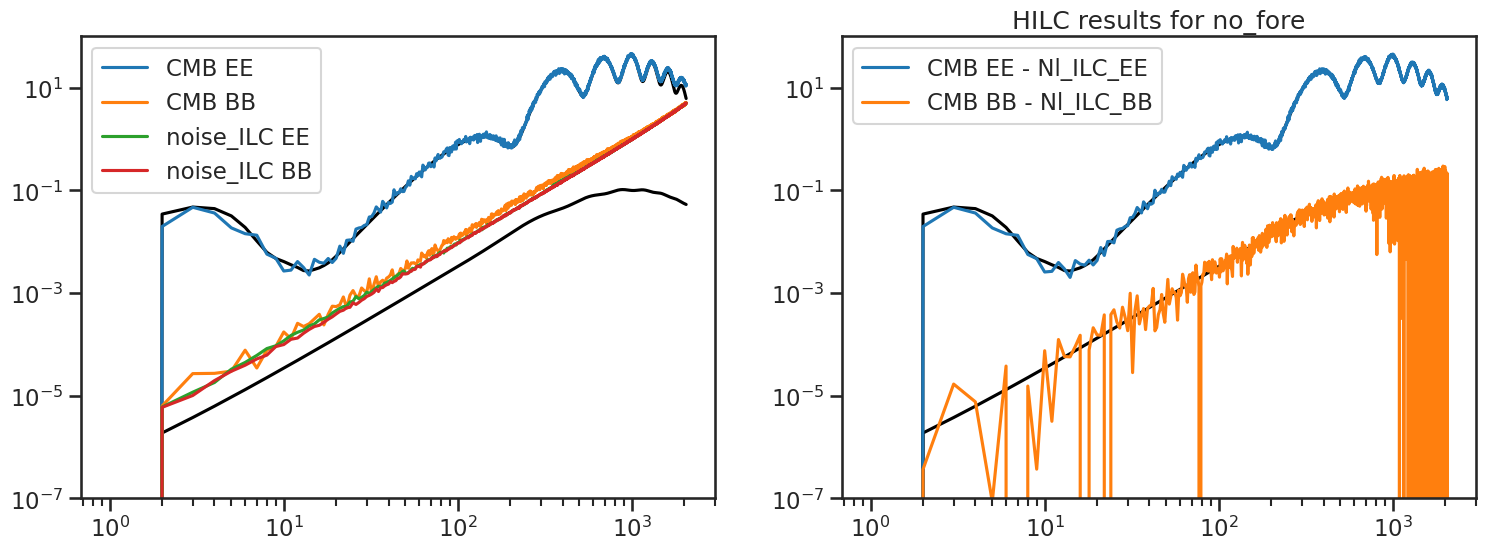

In [101]:
cls = hp.anafast(results.s[0], lmax = 2050)
fg_cls = hp.alm2cl(fg_res_alms)
nl = hp.alm2cl(noise_ilc_alms, lmax = 2050)

fig, axes = plt.subplots(1, 2, figsize = (18, 6))

Ell = lambda ell: ell*(ell+1)/2/np.pi
ells = np.arange(len(cls[0]))

for i in range(2):
    axes[i].loglog(ells, Ell(ells)*cl_lensed['ee'][0:2051], 'k-')
    axes[i].loglog(ells, Ell(ells)*cl_lensed['bb'][0:2051], 'k-')
    axes[i].set_ylim(1e-7, 1e2)

axes[i].set_title('HILC results for %s'%add_foreground)

axes[0].loglog(ells, Ell(ells)*cls[1], label = 'CMB EE')
axes[0].loglog(ells, Ell(ells)*cls[2], label = 'CMB BB')

# axes[0].loglog(ells, Ell(ells)*fg_cls[1], label = 'fg_ILC EE')
# axes[0].loglog(ells, Ell(ells)*fg_cls[2], label = 'fg_ILC BB')

axes[0].loglog(ells, Ell(ells)*nl_mean[1], label = 'noise_ILC EE')
axes[0].loglog(ells, Ell(ells)*nl_mean[2], label = 'noise_ILC BB')

axes[1].loglog(ells, Ell(ells)*(cls[1] - nl_mean[1]), label = 'CMB EE - Nl_ILC_EE')
axes[1].loglog(ells, Ell(ells)*(cls[2] - nl_mean[2]), label = 'CMB BB - Nl_ILC_BB')

for i in range(2):
    axes[i].legend()

####  debias with only one noise realization

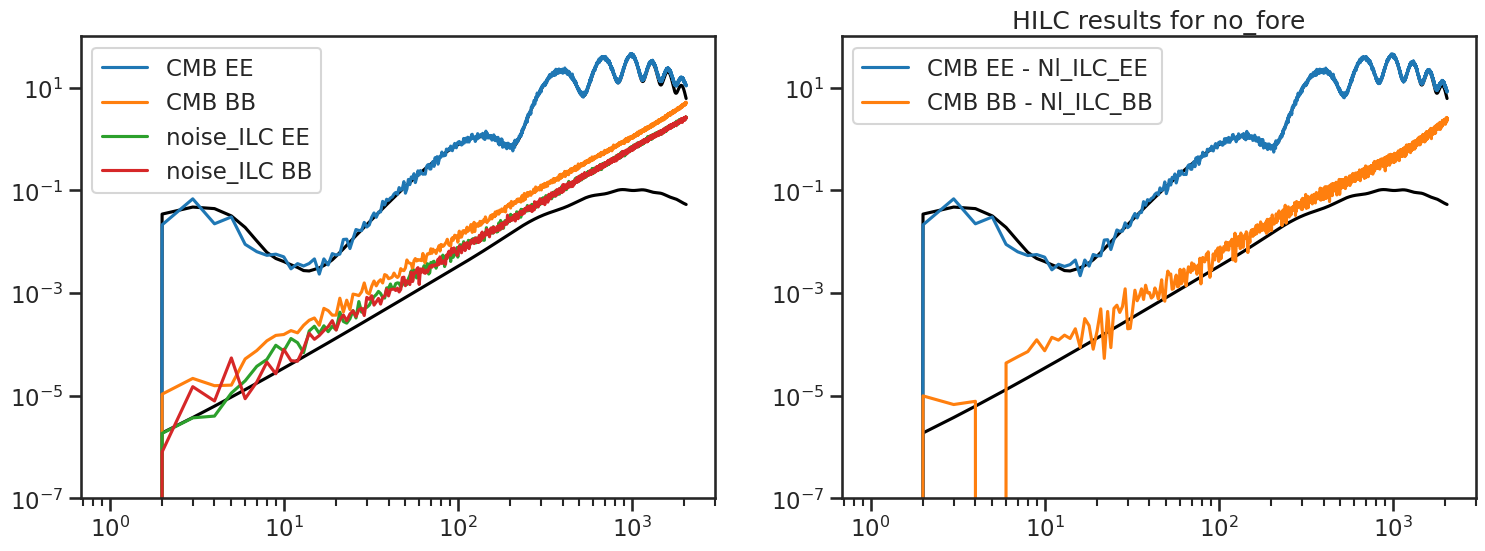

### noise + foreground

In [24]:
instrument

,frequency,depth_p,depth_i,fwhm,f_sky,status,reference,type,note,experiment
0,27.0,100.4,71.0,7.4,0.4,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_LAT
1,39.0,50.9,36.0,5.1,0.4,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_LAT
2,93.0,11.3,8.0,2.2,0.4,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_LAT
3,145.0,14.1,10.0,1.4,0.4,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_LAT
4,225.0,31.1,22.0,1.0,0.4,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_LAT
5,280.0,76.4,54.0,0.9,0.4,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_LAT


In [103]:
Ell = lambda ell: ell*(ell+1)/2/np.pi

def bin_cell(cls, lmax, bin_width):
    '''
    cls: list; cls including several XX or for only one XX, X means T, E, B
    bin_width: 
    lmax:
    
    Return
    ------
    ells_bin: binned ells, don't include multipoles beyond the last bin_edge defined by N*bin_width
    cls_bin: binned cell with factor ell*(ell+1)/2/np.pi applied
    
    '''
    N = lmax//bin_width
    
    if len(cls) != 6:
        cls = [cls]
        
    cls_bin = []
    for s in range(len(cls)):
        cls_bin_i = np.zeros(N)
        
        if s == 0:
            ells = np.arange(len(cls[0]))
            ells_bin = []
        
        for i in range(N):
            if s == 0:
                ells_bin.append(np.mean(ells[i*bin_width:(i+1)*bin_width]))
                
            cls_bin_i[i] = Ell(ells_bin[i])*np.mean(cls[s][i*bin_width:(i+1)*bin_width])
        
        cls_bin.append(cls_bin_i)
    
    return ells_bin, cls_bin

In [57]:
# cases = ['d0', 'd1', 'forse3_d0', 'forse3_d1']
# cases = ['d0', ]
cases = ['d9', 'd10', 'forse3_d0', 'forse3_d1']
results_all = []
for add_foreground in cases:

    nside = 1024
    instrument = get_instrument('SO_LAT')

    sims = simulations(nside, instrument, e_n_d = True)
    sims.get_all(add_foreground = add_foreground, noise = 'alms')

    components = [CMB()]
    lbins = np.arange(42)*50

    results_i = sims.apply_hilc(components, lbins)
    results_all.append(results_i)
    # cleaned_CMB = hp.read_map('/pscratch/sd/j/jianyao/data_lensing/cleaned_CMB/SO_LAT/CMB_map_from_SO_LAT_%s_HILC_lbins_42x50_lmax_2050_nside_1024_%04d.fits'%(add_foreground, mc), field = None)

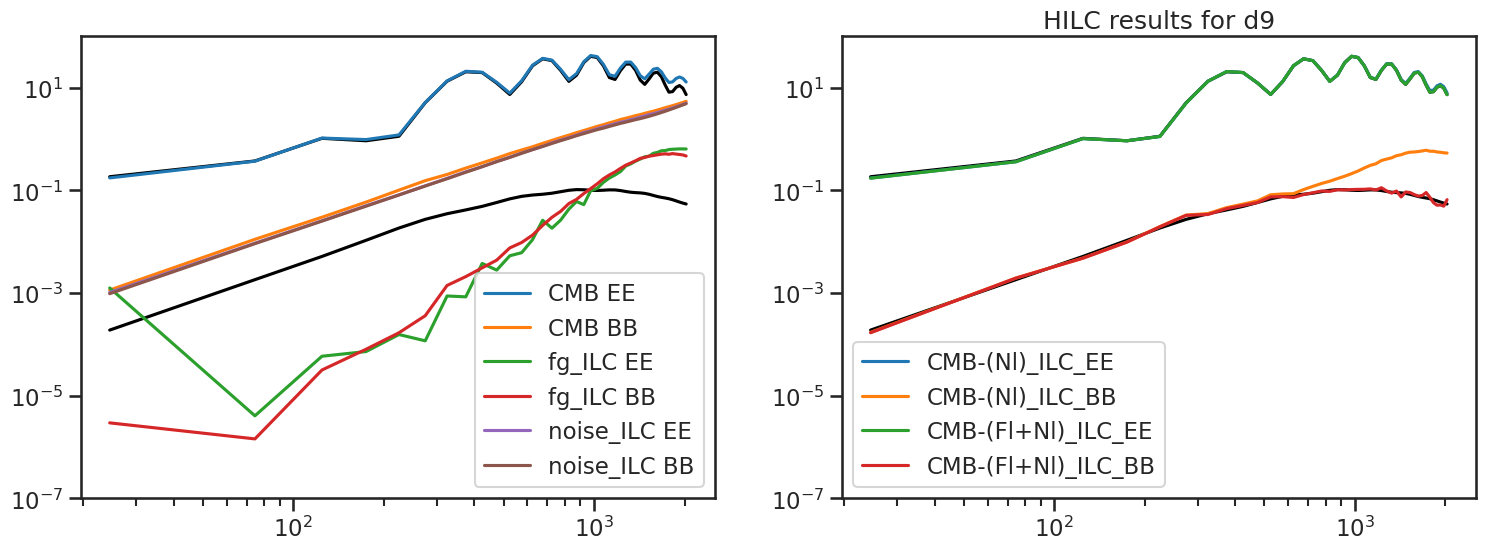

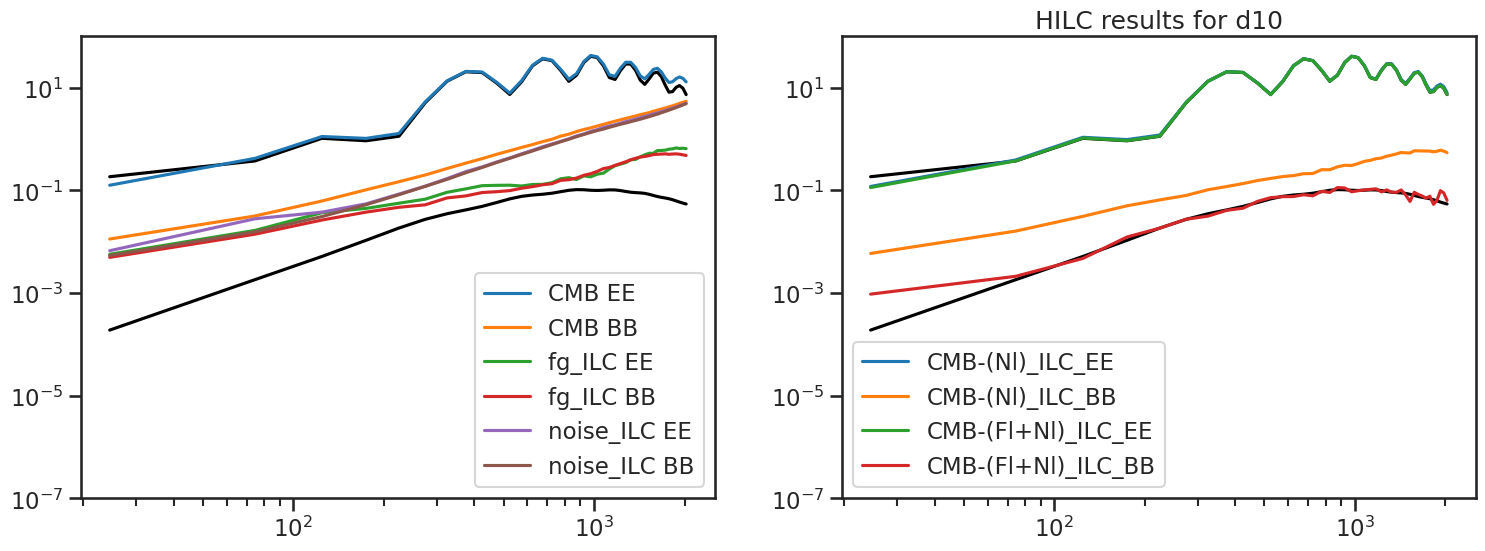

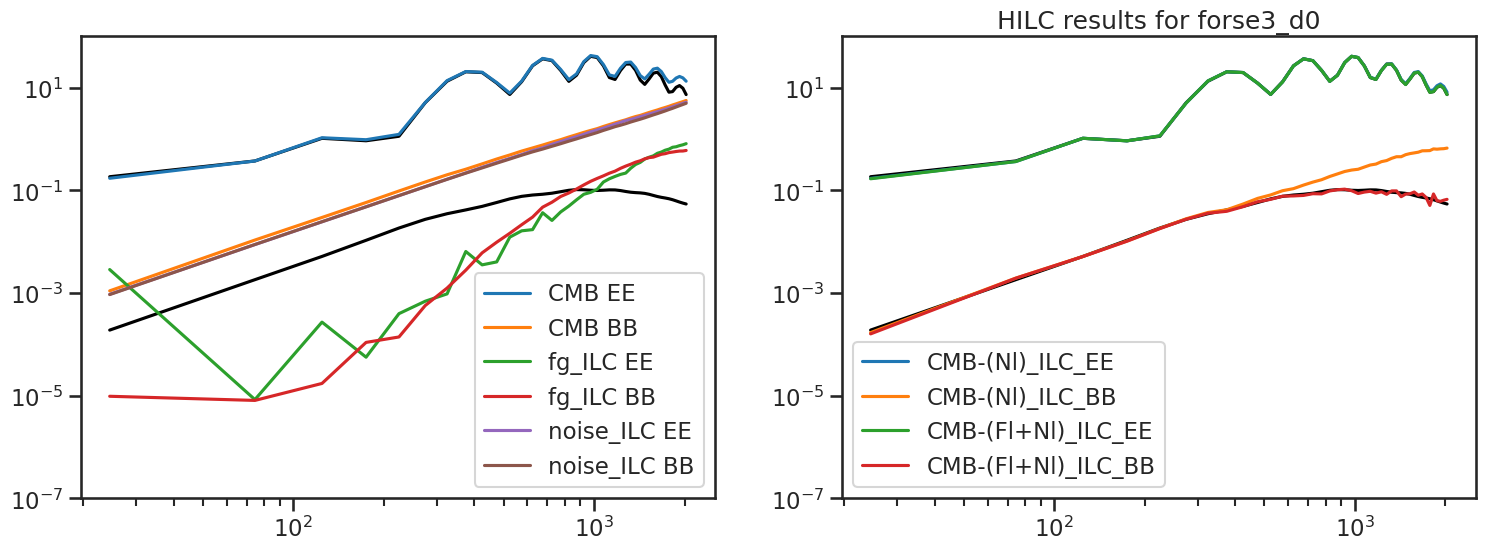

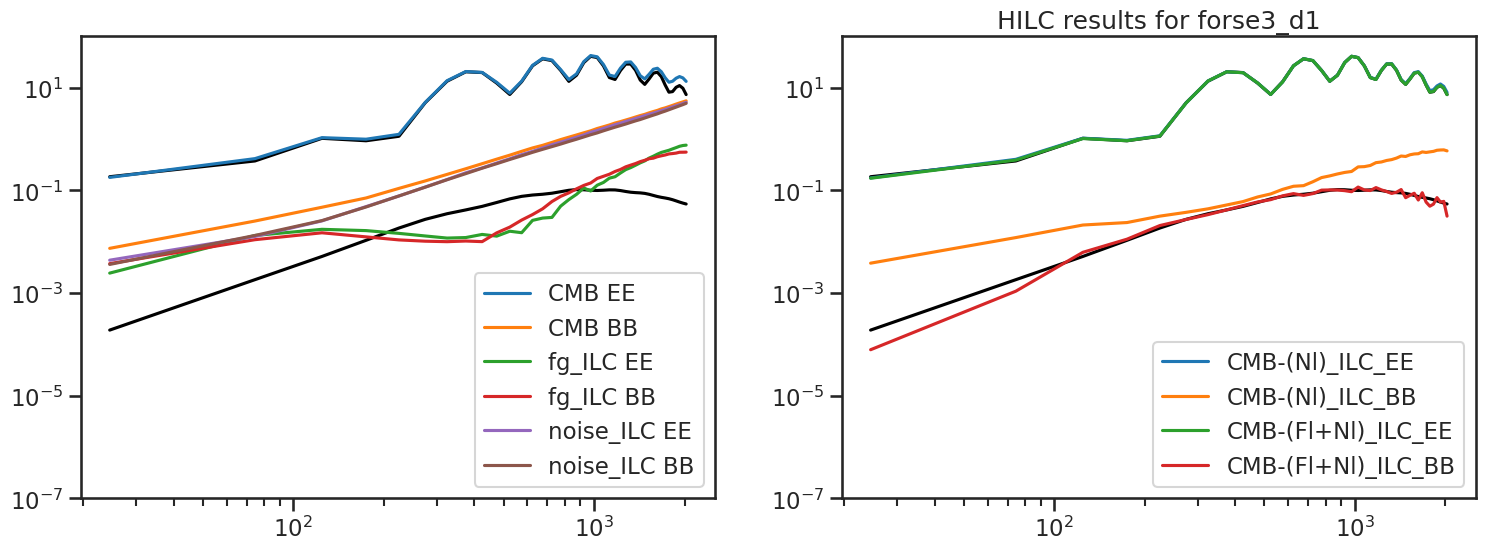

In [106]:
for c, add_foreground in zip(range(len(cases)), cases):

    results, noise_ilc_alms, fg_res_alms, nls = results_all[c]

    cls = hp.anafast(results.s[0], lmax = 2050)
    fg_cls = hp.alm2cl(fg_res_alms)
    nl = hp.alm2cl(noise_ilc_alms, lmax = 2050)

    nl_mean = np.mean(nls, axis = 0)
    
    ells, cl_bin = bin_cell(cls, lmax = 2050, bin_width = 50)
    ells, fl_bin = bin_cell(fg_cls, lmax = 2050, bin_width = 50)
    ells, nl_bin = bin_cell(nl_mean, lmax = 2050, bin_width = 50)
    
    ells, cl_ee = bin_cell(cl_lensed['ee'][0:2051], lmax = 2050, bin_width = 50)
    ells, cl_bb = bin_cell(cl_lensed['bb'][0:2051], lmax = 2050, bin_width = 50)
    
    fig, axes = plt.subplots(1, 2, figsize = (18, 6))

    Ell = lambda ell: ell*(ell+1)/2/np.pi
    # ells = np.arange(len(cls[0]))

    for i in range(2):
        axes[i].loglog(ells, cl_ee[0], 'k-')
        axes[i].loglog(ells, cl_bb[0], 'k-')
        axes[i].set_ylim(1e-7, 1e2)

    axes[i].set_title('HILC results for %s'%add_foreground)

    axes[0].loglog(ells, cl_bin[1], label = 'CMB EE')
    axes[0].loglog(ells, cl_bin[2], label = 'CMB BB')

    axes[0].loglog(ells, fl_bin[1], label = 'fg_ILC EE')
    axes[0].loglog(ells, fl_bin[2], label = 'fg_ILC BB')

    axes[0].loglog(ells, nl_bin[1], label = 'noise_ILC EE')
    axes[0].loglog(ells, nl_bin[2], label = 'noise_ILC BB')

    axes[1].loglog(ells, (cl_bin[1] - nl_bin[1]), label = 'CMB-(Nl)_ILC_EE')
    axes[1].loglog(ells, (cl_bin[2] - nl_bin[2]), label = 'CMB-(Nl)_ILC_BB')
    
    axes[1].loglog(ells, (cl_bin[1] - nl_bin[1] - fl_bin[1]), label = 'CMB-(Fl+Nl)_ILC_EE')
    axes[1].loglog(ells, (cl_bin[2] - nl_bin[2] - fl_bin[2]), label = 'CMB-(Fl+Nl)_ILC_BB')

    for i in range(2):
        axes[i].legend()

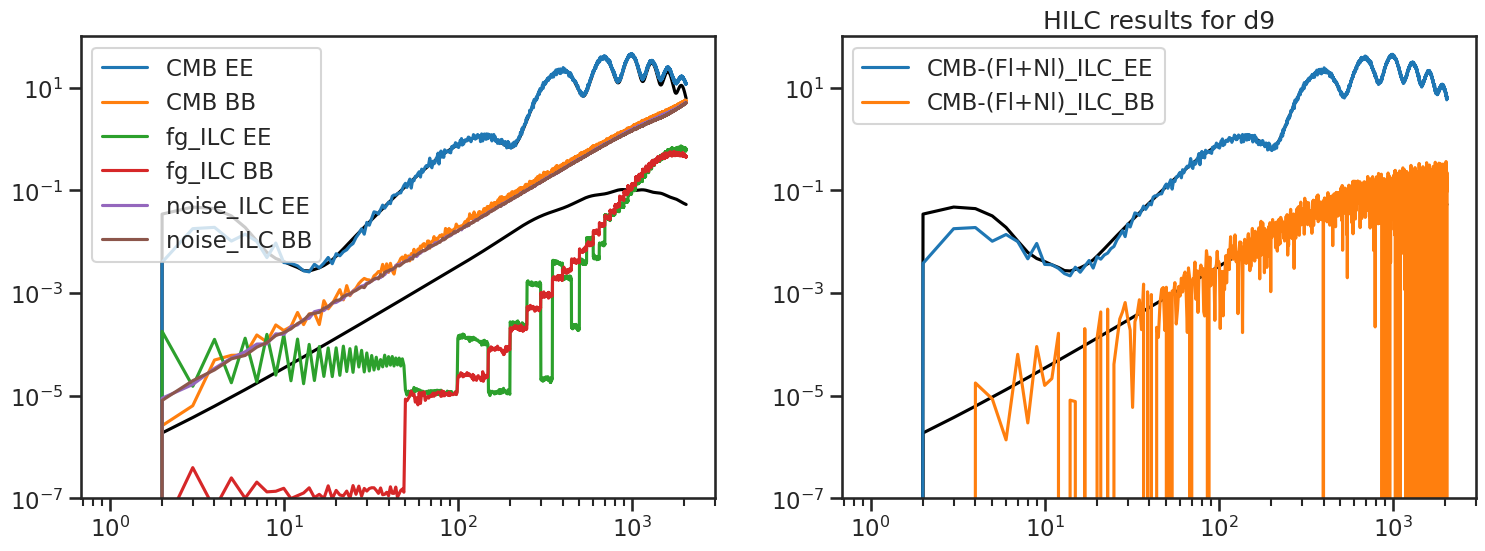

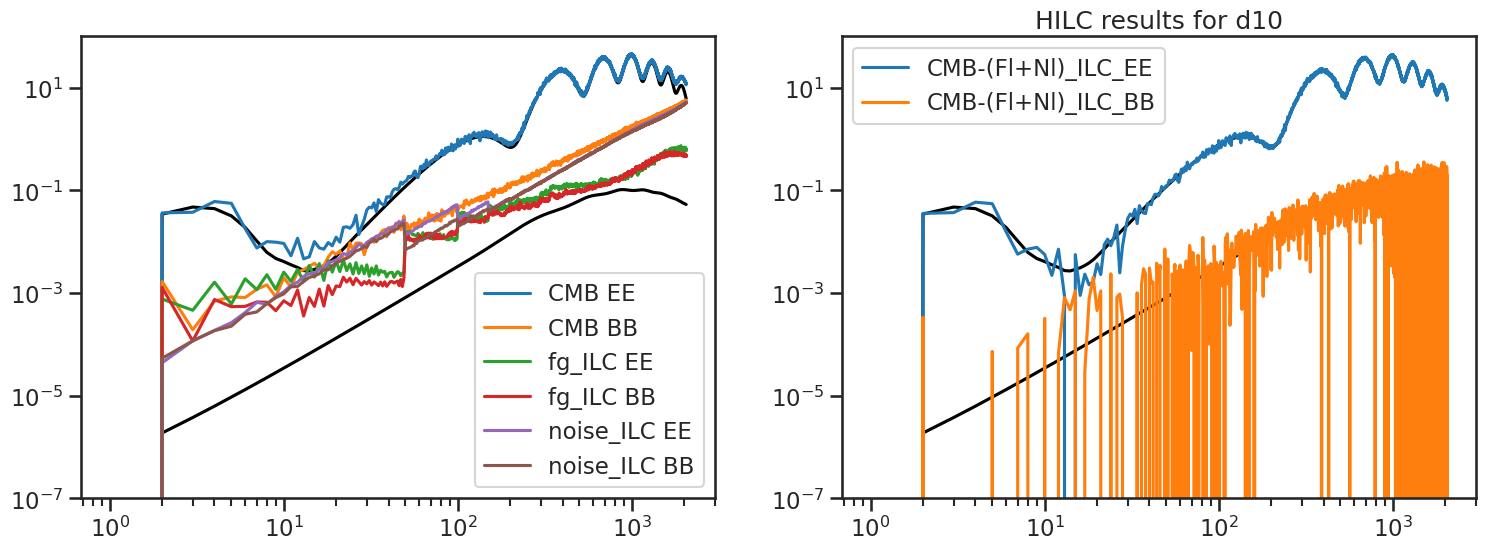

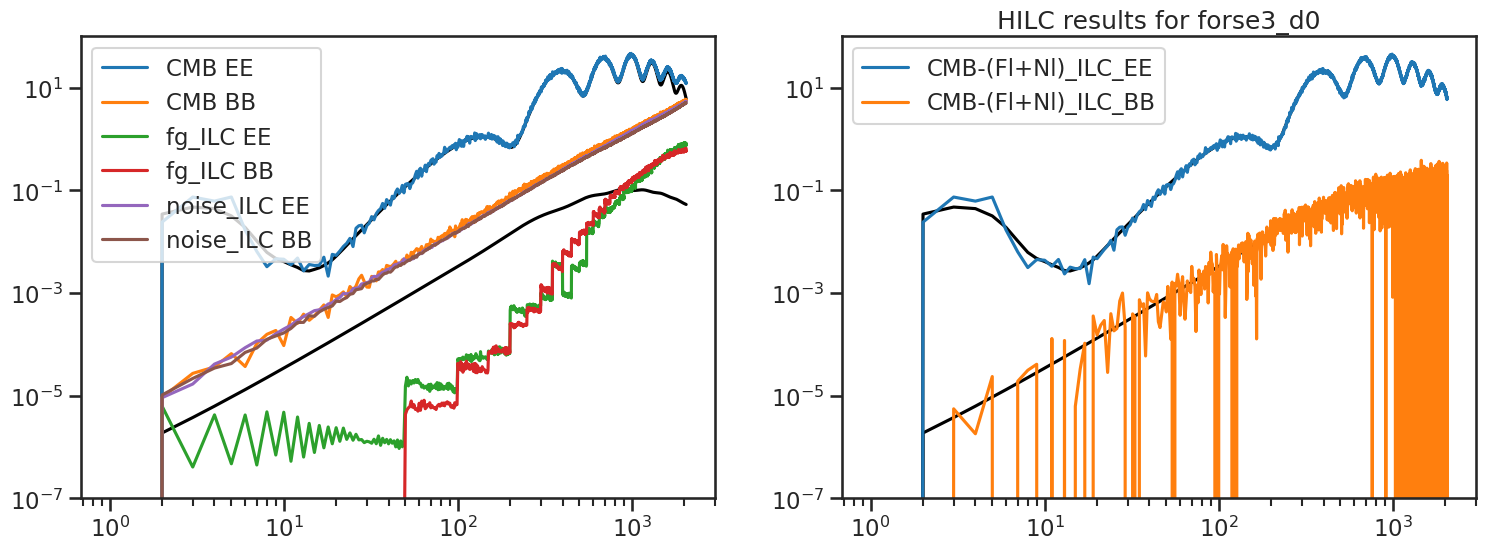

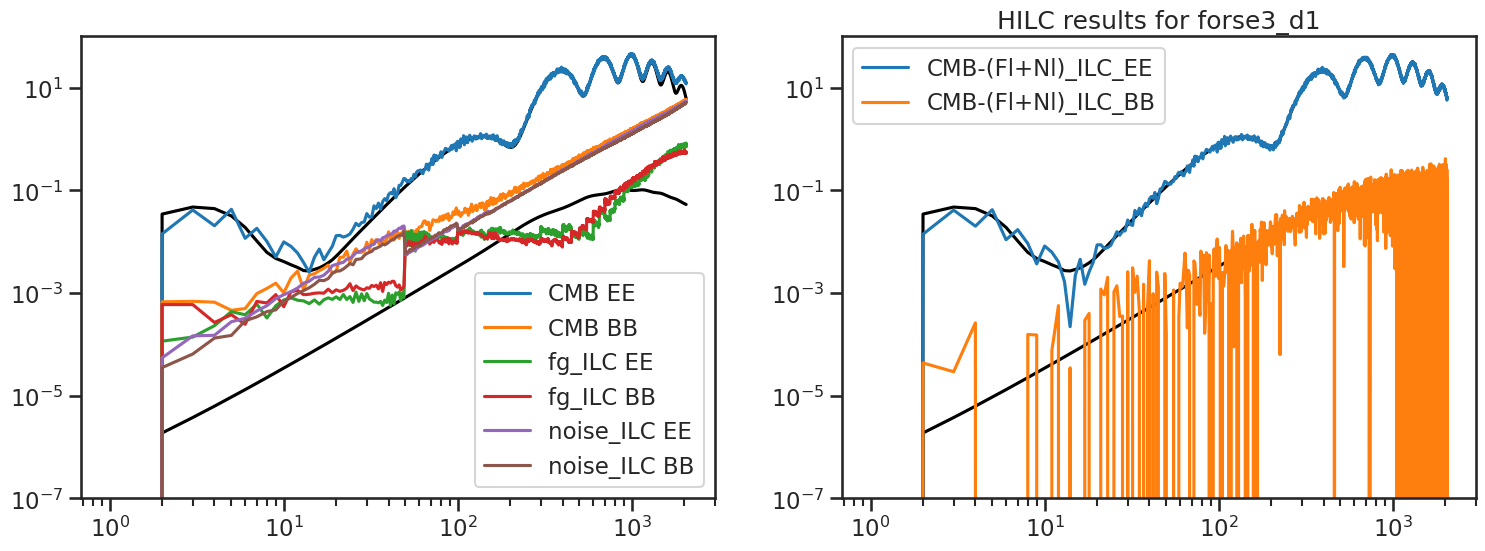

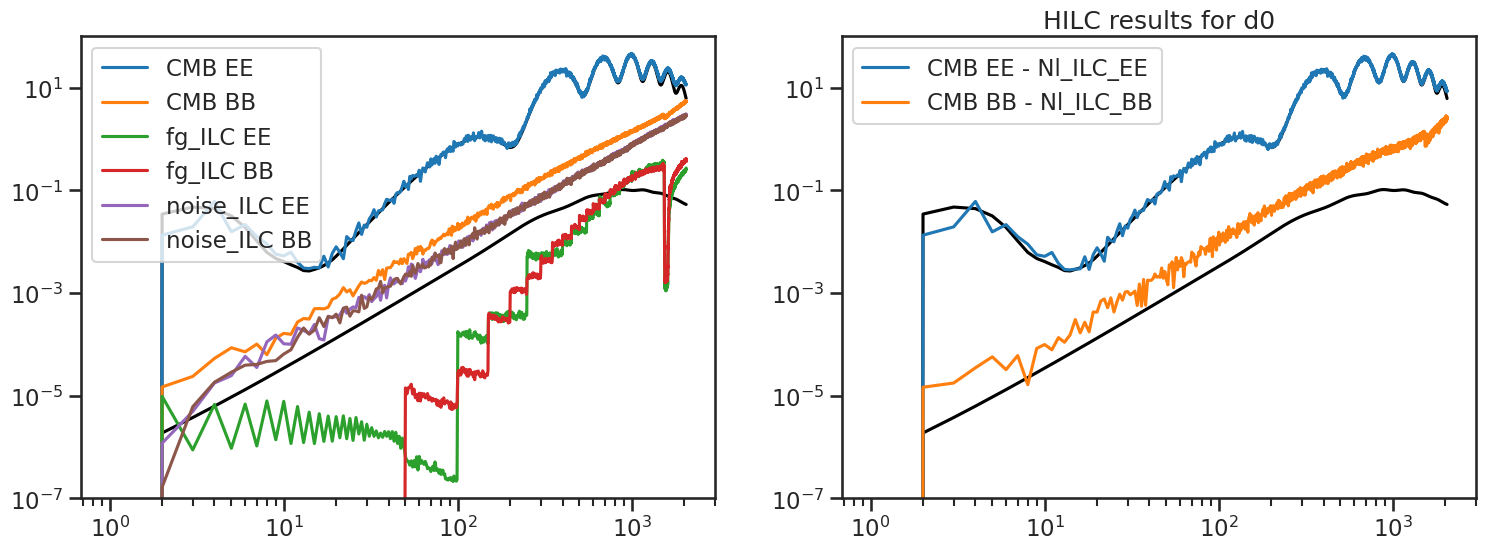

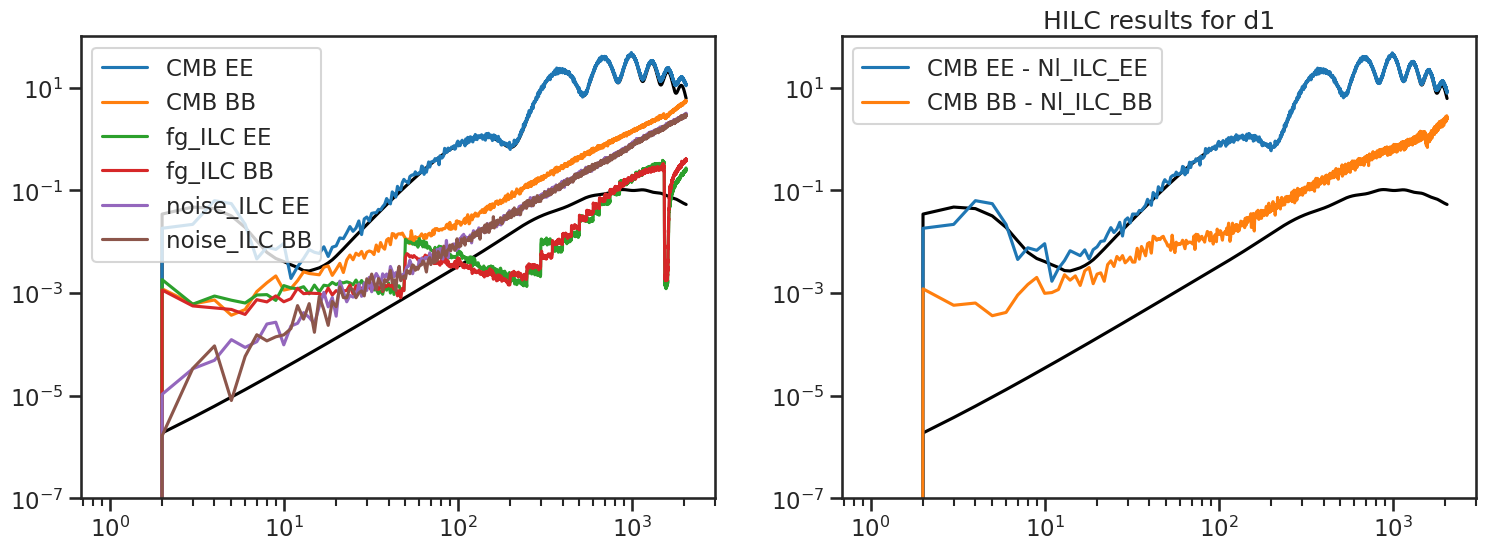

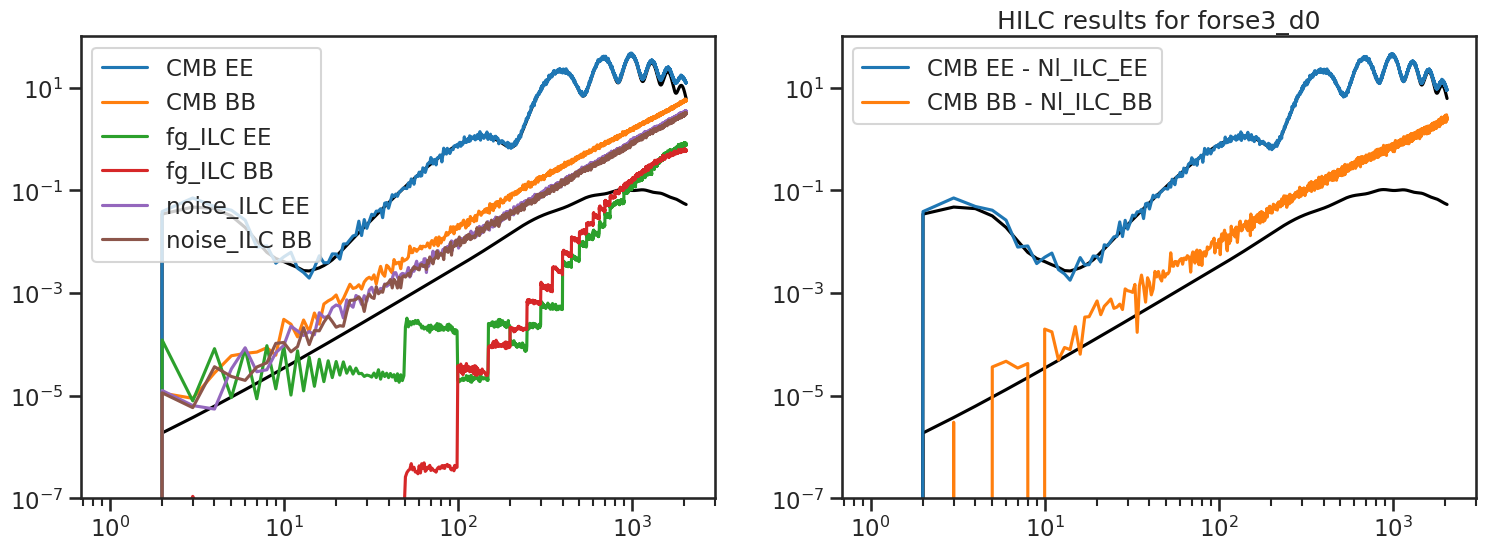

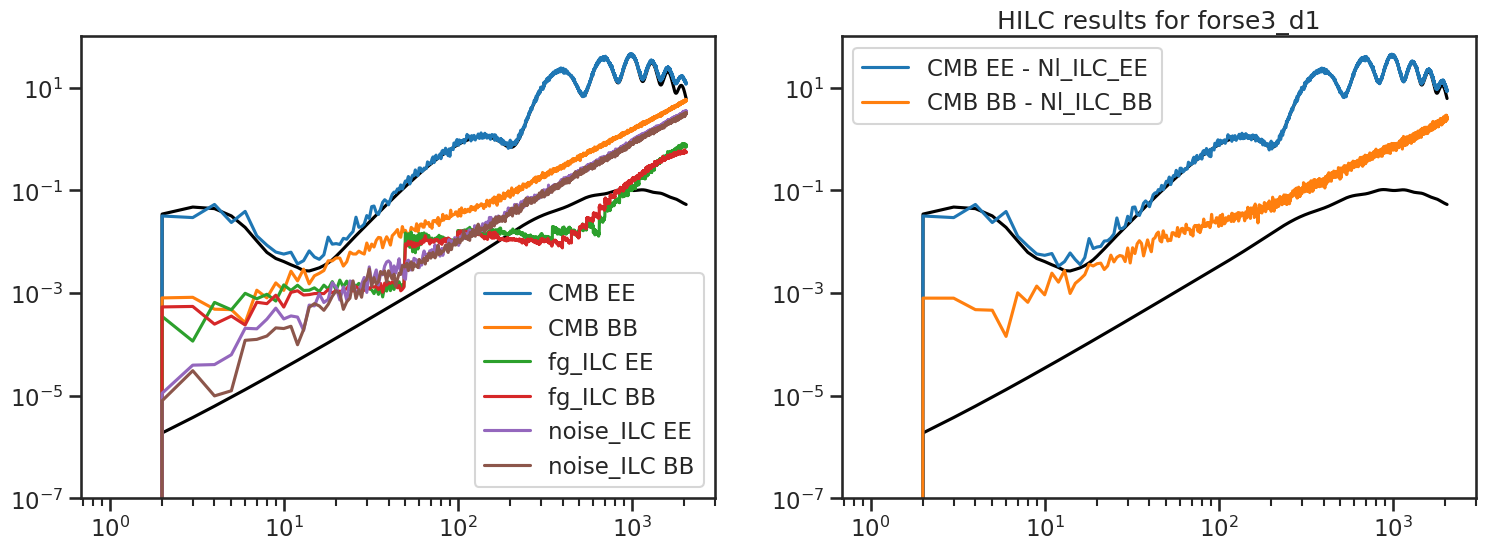